In [1]:
import gurobipy as gb

import pandas as pd

from data_generator import *

from extractor import extract_problem_data

In [5]:
days, slots_per_day, nb_resources, nb_projects, resources, projects = extract_problem_data(filename="data/instance_2.txt")

In [6]:
squash_factor= 1 # value that indicate how much to squash the planning of the project. It need to be >= 1

# calculate data
total_time_slots = days * slots_per_day
BIG_M = max(2*total_time_slots, 99)

#calculate max allocation
max_total_allocation = total_time_slots * nb_resources
print("max_total_allocation", max_total_allocation)

max_total_allocation 80


In [7]:
env = gb.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

model = gb.Model()

model.modelSense = gb.GRB.MINIMIZE  #declare minimization

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-10


In [8]:
# variables definition

X = {}
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            X[(p, r, t)] = model.addVar(vtype=gb.GRB.BINARY, name=f"X_p{p}_r{r}_t{t}")
S = {}
F = {}
for p in range(nb_projects):
    S[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"S_p{p}")
    F[(p)] = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"F_p{p}")


Y = model.addVar(vtype=gb.GRB.INTEGER, lb=0, ub=total_time_slots, name=f"Y")

for v in model.getVars():
    print(v.varName)

In [9]:
# constraint 1
# Define constraint: Total working time for each project respect the request
for p in range(nb_projects):
    model.addConstr(sum(X[(p, r, t)] for r in range(nb_resources) for t in range(total_time_slots)) == projects[p].requested_slots)

# constraint 2
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(t * X[(p, r, t)] <= F[p])

# constraint 3
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            model.addConstr(S[p] <= t*X[(p, r, t)]+(1-X[(p, r, t)])*BIG_M)

# constraint 4
# constraint assign lower bound of y
for p in range(nb_projects):
    model.addConstr(F[p] <= Y)

# constraint 5
for p in range(nb_projects):
    model.addConstr(F[p]-S[p]+1 <= projects[p].requested_slots*squash_factor)

# constraint 6
# constraints no double booking
for r in range(nb_resources):
    for t in range(total_time_slots):
        model.addConstr(sum(X[(p, r, t)] for p in range(nb_projects)) <= 1)

# constraint 7
# on each project only some resources can work on it
for project in projects:
    for resource in resources:
        if(not project.is_resource_assigned(resource)):
            for t in range(total_time_slots):
                model.addConstr(X[project.id, resource.id, t] == 0)

In [10]:
model.setObjective(Y, gb.GRB.MINIMIZE)

In [11]:
print("Variables: ",model.NumVars)
print("Constraints: ",model.NumConstrs)

Variables:  0
Constraints:  0


In [12]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1075 rows, 411 columns and 2580 nonzeros
Model fingerprint: 0xad3d7f64
Variable types: 0 continuous, 411 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 2.0000000
Presolve removed 1042 rows and 379 columns
Presolve time: 0.01s
Presolved: 33 rows, 32 columns, 95 nonzeros
Variable types: 0 continuous, 32 integer (32 binary)

Root relaxation: infeasible, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0

In [13]:

for p in range(nb_projects):
    print(f"project {p} : S", S[p].x, " F:",F[p].x)

print('Y =', Y.x)


# show all the assignation
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            if(X[(p, r, t)].x == 1.0):
                print("project: ", p, "resource:", r, " time:",t)

project 0 : S 0.0  F: 1.0
project 1 : S 1.0  F: 2.0
project 2 : S 1.0  F: 2.0
project 3 : S -0.0  F: 2.0
project 4 : S 1.0  F: 2.0
Y = 2.0
project:  0 resource: 0  time: 0
project:  0 resource: 3  time: 0
project:  1 resource: 0  time: 2
project:  1 resource: 1  time: 2
project:  2 resource: 0  time: 1
project:  2 resource: 1  time: 1
project:  3 resource: 1  time: 0
project:  3 resource: 2  time: 0
project:  3 resource: 3  time: 2
project:  4 resource: 2  time: 1
project:  4 resource: 2  time: 2


In [14]:
np_array = np.zeros((nb_projects, nb_resources, total_time_slots))

# Populate the array with the values of the decision variables
for p in range(nb_projects):
    for r in range(nb_resources):
        for t in range(total_time_slots):
            if(X[(p, r, t)].x == 1.0):
                np_array[p, r, t] = 1

# cut the extra slot that are not used
max_time_slot = int(Y.x)

sliced_array = np_array[:, :, :max_time_slot+1]

reshaped_array = sliced_array.reshape(nb_projects * nb_resources, max_time_slot+1)

df = pd.DataFrame(reshaped_array)
df.index = [i for i in range(nb_resources)]*nb_projects # define the lef header

print(df)

     0    1    2
0  1.0  0.0  0.0
1  0.0  0.0  0.0
2  0.0  0.0  0.0
3  1.0  0.0  0.0
0  0.0  0.0  1.0
1  0.0  0.0  1.0
2  0.0  0.0  0.0
3  0.0  0.0  0.0
0  0.0  1.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  0.0
3  0.0  0.0  0.0
0  0.0  0.0  0.0
1  1.0  0.0  0.0
2  1.0  0.0  0.0
3  0.0  0.0  1.0
0  0.0  0.0  0.0
1  0.0  0.0  0.0
2  0.0  1.0  1.0
3  0.0  0.0  0.0


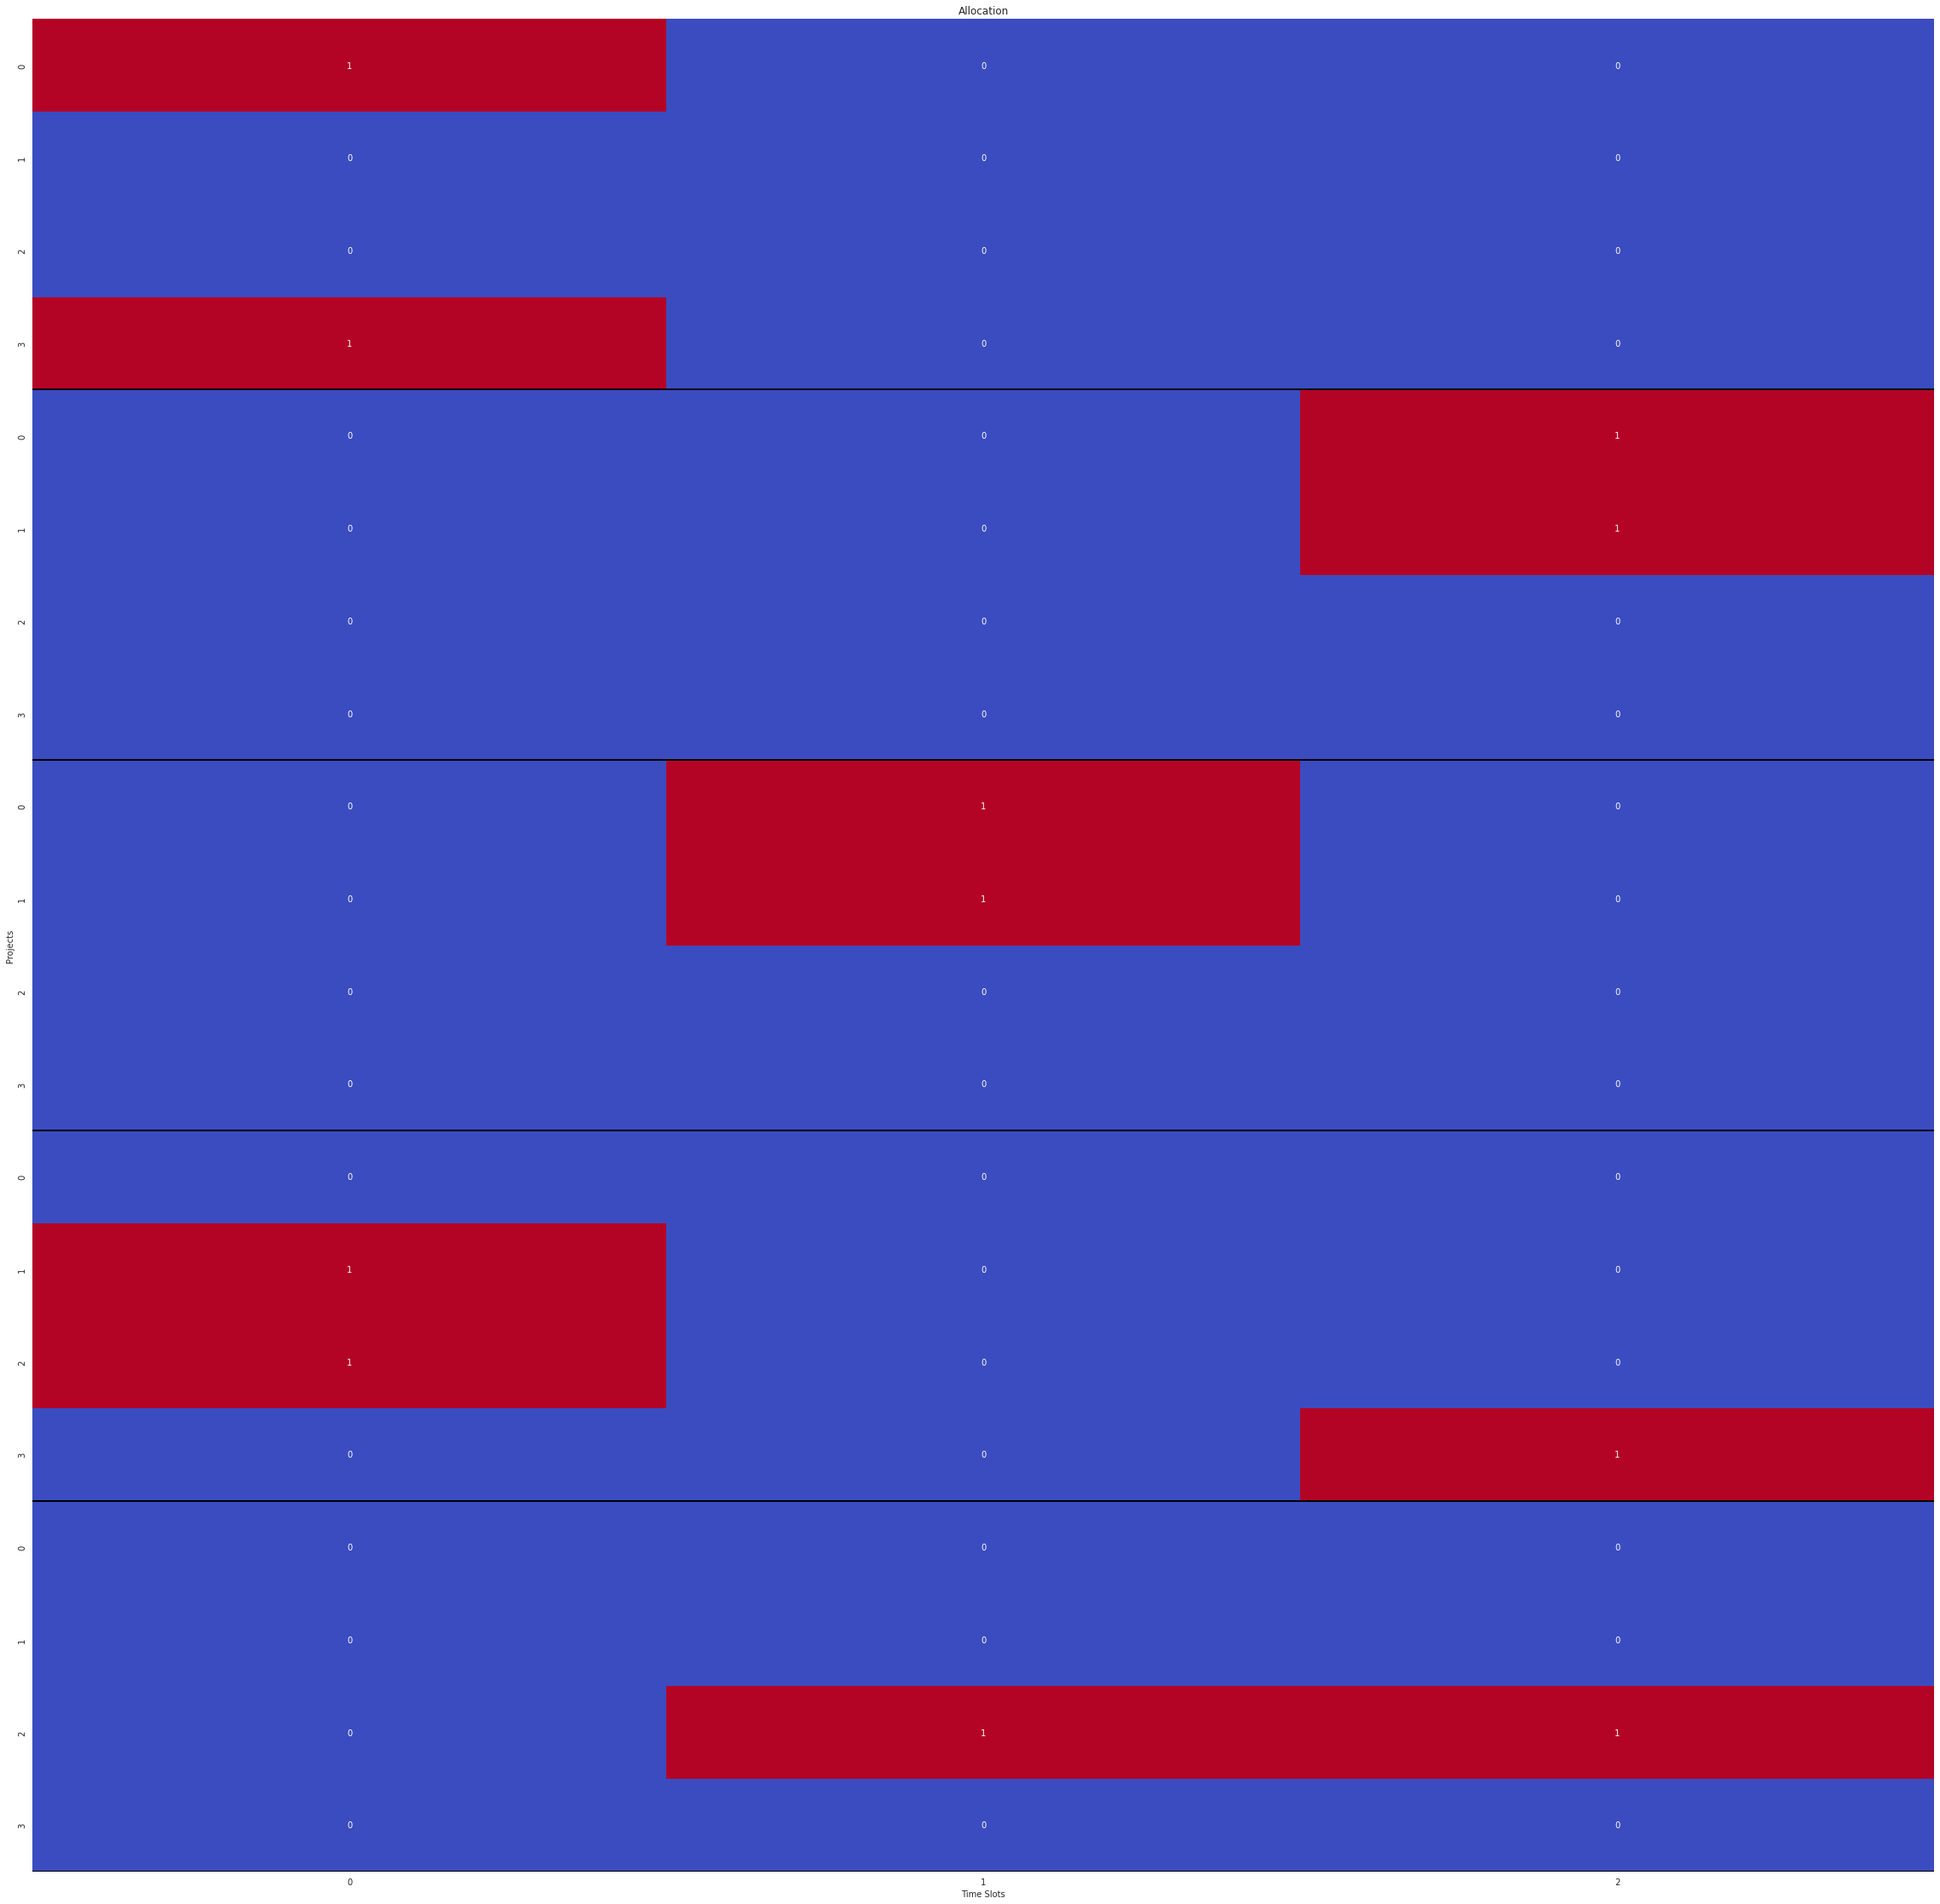

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(40, 40))  # Adjust the size as needed
# Add lines for separation
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='g', cbar=False)
group_end_indices = [nb_resources+i*nb_resources for i in range(nb_projects)]
for index in group_end_indices:
    plt.axhline(y=index, color='black', linewidth=2)

# Adding titles and labels for clarity
plt.title('Allocation')
plt.xlabel('Time Slots')
plt.ylabel('Projects')

plt.show()